In [35]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from scipy import stats

In [36]:
df = pd.read_csv("./data.csv",encoding='unicode_escape') #Reading the csv file 

In [37]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


## Data Description

1. **InvoiceNo:** The unique identifier of each customer invoice.
2. **StockCode:** The unique identifier of each item in stock.
3. **Description:** The item purchased by the customer.
4. **Quantity:** The number of each item purchased by a customer in a single invoice.
5. **InvoiceDate:** The purchase date.
6. **UnitPrice:** Price of one unit of each item.
7. **CustomerID:** Unique identifier assigned to each user.
8. **Country:** The country from where the purchase was made.


We check for the type of values in each column and how many null values are there.

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


Dealing with NULL values of Description and CustomerID columns by removing them as we can't generate them using statistical methods for others we will us imputers.

In [39]:
df = df.dropna(subset=['Description']) #removing null values from the description column
df = df.dropna(subset=['CustomerID']) #removing null values from the description column
df = df.drop_duplicates() #removing duplicates
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 401604 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    401604 non-null  object 
 1   StockCode    401604 non-null  object 
 2   Description  401604 non-null  object 
 3   Quantity     401604 non-null  int64  
 4   InvoiceDate  401604 non-null  object 
 5   UnitPrice    401604 non-null  float64
 6   CustomerID   401604 non-null  float64
 7   Country      401604 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.6+ MB


In [40]:
df['Description'] = df['Description'].str.strip() #removing leading and trailing whitespaces from the description column

In [41]:
df.describe()  #describing the data

,Quantity,UnitPrice,CustomerID
count,401604.000000,401604.000000,401604.000000
mean,12.183273,3.474064,15281.160818
std,250.283037,69.764035,1714.006089
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13939.000000
50%,5.000000,1.950000,15145.000000
75%,12.000000,3.750000,16784.000000
max,80995.000000,38970.000000,18287.000000


We see that Quantity and UnitPrice have negative values which is not possible. Hence we will remove these rows.

In [42]:
df = df[df['Quantity'] > 0] #removing negative values from the quantity column
df = df[df['UnitPrice'] > 0] #removing negative values from the unit price column
df.describe()

,Quantity,UnitPrice,CustomerID
count,392692.000000,392692.000000,392692.000000
mean,13.119702,3.125914,15287.843865
std,180.492832,22.241836,1713.539549
min,1.000000,0.001000,12346.000000
25%,2.000000,1.250000,13955.000000
50%,6.000000,1.950000,15150.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,8142.750000,18287.000000


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392692 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    392692 non-null  object 
 1   StockCode    392692 non-null  object 
 2   Description  392692 non-null  object 
 3   Quantity     392692 non-null  int64  
 4   InvoiceDate  392692 non-null  object 
 5   UnitPrice    392692 non-null  float64
 6   CustomerID   392692 non-null  float64
 7   Country      392692 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.0+ MB


Drawing a heatmap between Quantity and Unit price to find correlation of variables.

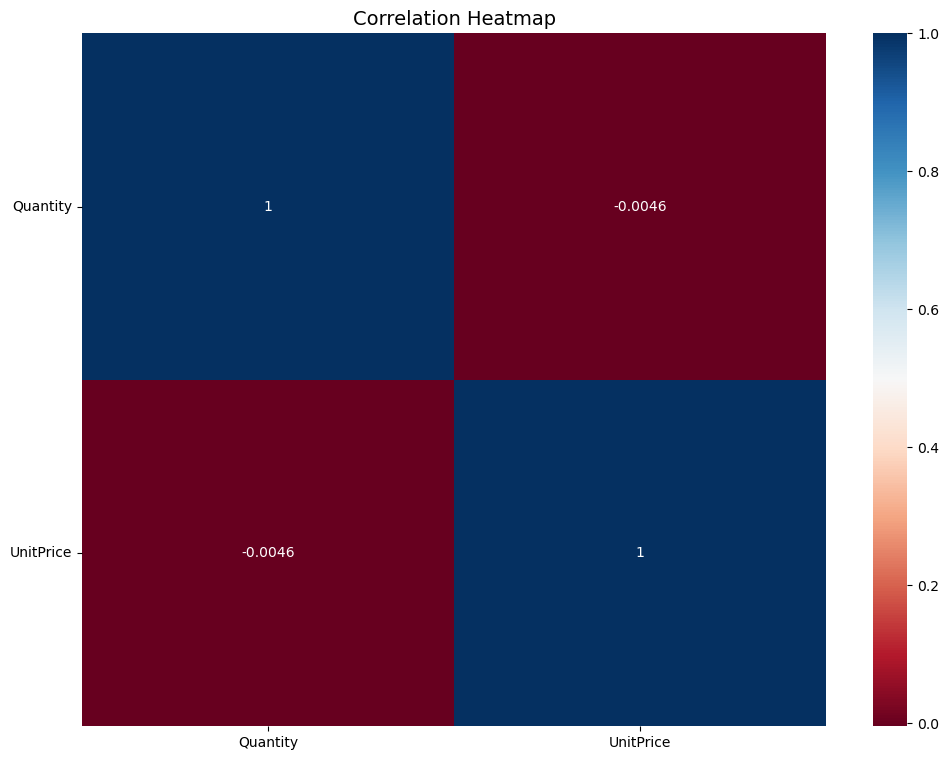

In [44]:
plt.figure(figsize=(12,9))
sns.heatmap(df[["Quantity","UnitPrice"]].corr(),annot=True,cmap='RdBu')
plt.title('Correlation Heatmap',fontsize=14)
plt.yticks(rotation=0)
plt.show()

The above heatmap shows data has no correlation between Quantity and UnitPrice.

In [45]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice'] #creating a new column for total price

In [46]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']) #converting the invoice date to datetime

Calculating RFM values for each customer:

- **Recency:** How recently a customer made a purchase. It indicates the time elapsed since the customer's last purchase.

- **Frequency:** How often a customer makes a purchase. It represents the total number of purchases made by the customer within a specific period.

- **Monetary:** The monetary value of the customer's purchases. It reflects the total amount of money spent by the customer on purchases within a specific period.

RFM analysis is a technique used in customer segmentation and marketing strategies, where customers are grouped based on their recent purchasing behavior, frequency of purchases, and monetary value. It helps businesses identify their most valuable customers, understand their behaviors, and tailor marketing efforts to improve customer engagement and retention.

In [47]:
ref_date = max(df['InvoiceDate']) + pd.DateOffset(days=1)
ref_date

Timestamp('2011-12-10 12:50:00')

In [48]:
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (ref_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
})

In [49]:
rfm.rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'TotalPrice': 'Monetary'}, inplace=True)
rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40


In [50]:
rfm.describe()

,Recency,Frequency,Monetary
count,4338.000000,4338.000000,4338.000000
mean,92.536422,4.272015,2048.688081
std,100.014169,7.697998,8985.230220
min,1.000000,1.000000,3.750000
25%,18.000000,1.000000,306.482500
50%,51.000000,2.000000,668.570000
75%,142.000000,5.000000,1660.597500
max,374.000000,209.000000,280206.020000


Checking the distribution of RFM values and removing outliers.

Recency: 


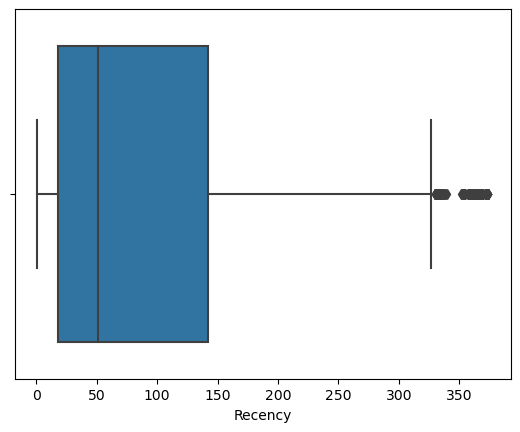

Frequency: 


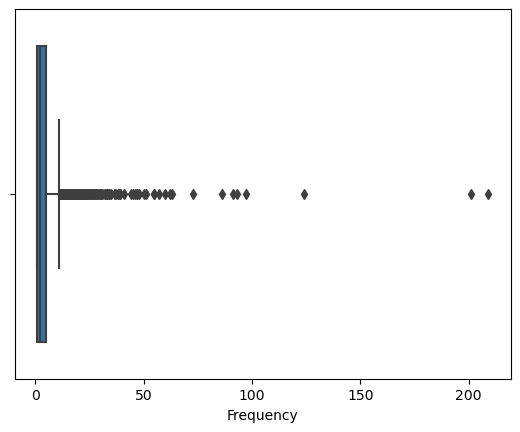

Monetary: 


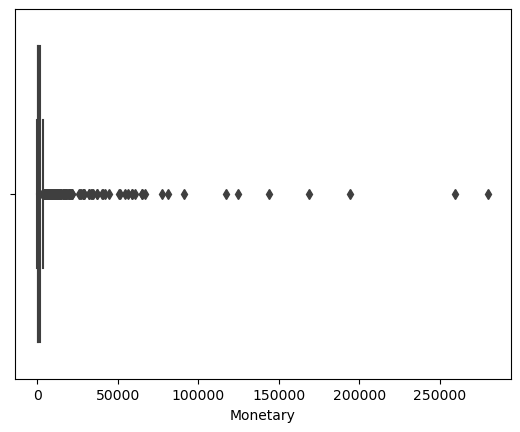

In [51]:
list1 = ['Recency','Frequency','Monetary']
for i in list1:
    print(str(i)+': ')
    ax = sns.boxplot(x=rfm[str(i)])
    plt.show()

In [52]:
# remove the customer id column
new_df = rfm[['Recency','Frequency','Monetary']]
# remove outliers
z_scores = stats.zscore(new_df)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
rfm = rfm[filtered_entries]

Recency: 


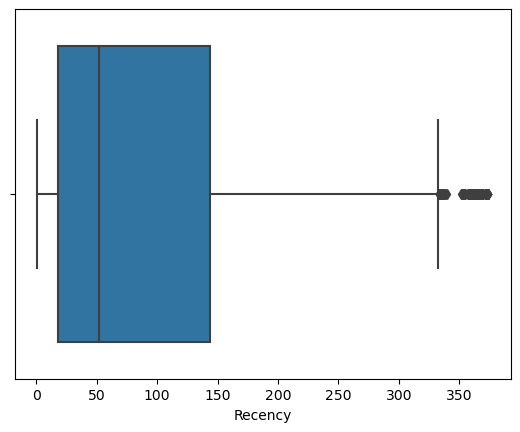

Frequency: 


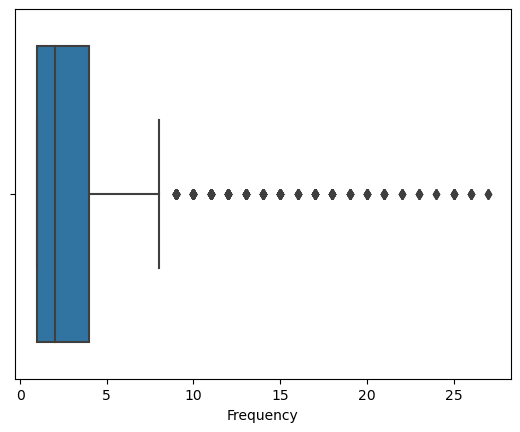

Monetary: 


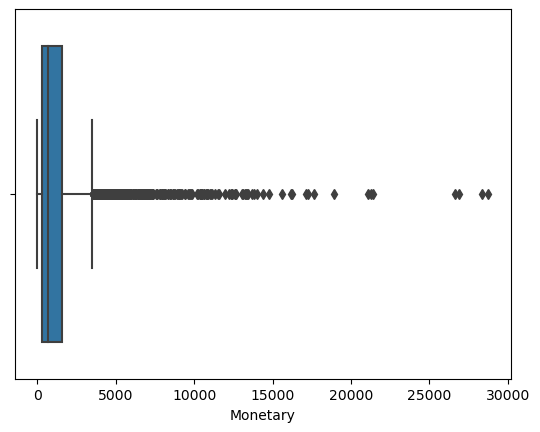

In [53]:
list1 = ['Recency','Frequency','Monetary']
for i in list1:
    print(str(i)+': ')
    ax = sns.boxplot(x=rfm[str(i)])
    plt.show()

Scaling the RFM values using MinMaxScaler.

In [54]:
scaler = MinMaxScaler()
# Fit and transform the data
rfm = pd.DataFrame(scaler.fit_transform(rfm)).rename(columns={0: 'Recency', 1: 'Frequency', 2: 'Monetary'})
rfm.head()

,Recency,Frequency,Monetary
0,0.002681,0.230769,0.149781
1,0.198391,0.115385,0.062381
2,0.048257,0.000000,0.061001
3,0.828418,0.000000,0.011501
4,0.093834,0.269231,0.087035


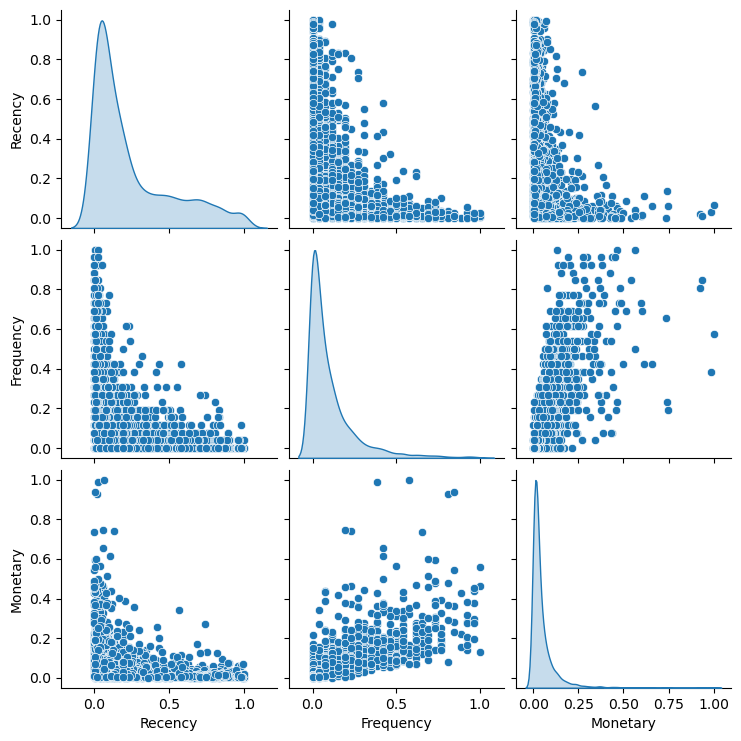

In [55]:
sns.pairplot(rfm, diag_kind='kde') #Bivariate analysis

In [56]:
rfm.describe()

,Recency,Frequency,Monetary
count,4274.000000,4274.000000,4274.000000
mean,0.248199,0.102624,0.048002
std,0.268202,0.150508,0.074724
min,0.000000,0.000000,0.000000
25%,0.046247,0.000000,0.010445
50%,0.136729,0.038462,0.022656
75%,0.383378,0.115385,0.055129
max,1.000000,1.000000,1.000000


Categories for RFM values are created based on quantiles.

In [57]:
# Calculate custom bin edges for Recency, Frequency, and Monetary scores as per quartiles
recency_bins = [rfm['Recency'].min(), 0.05, 0.15, 0.40, rfm['Recency'].max()]
frequency_bins = [rfm['Frequency'].min(), 10e-3, 0.040, 0.12, rfm['Frequency'].max()]
monetary_bins = [rfm['Monetary'].min(), 0.010, 0.022, 0.55, rfm['Monetary'].max()]

In [58]:
# Calculate Recency score based on custom bins 
rfm['R_Score'] = pd.cut(rfm['Recency'], bins=recency_bins, labels=range(1, 5), include_lowest=True)

# Reverse the Recency scores so that higher values indicate more recent purchases
rfm['R_Score'] = 5 - rfm['R_Score'].astype(int) + 1

# Calculate Frequency and Monetary scores based on custom bins
rfm['F_Score'] = pd.cut(rfm['Frequency'], bins=frequency_bins, labels=range(1, 5), include_lowest=True).astype(int)
rfm['M_Score'] = pd.cut(rfm['Monetary'], bins=monetary_bins, labels=range(1, 5), include_lowest=True).astype(int)

In [59]:
rfm.head()

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score
0,0.002681,0.230769,0.149781,5,4,3
1,0.198391,0.115385,0.062381,3,3,3
2,0.048257,0.000000,0.061001,5,1,3
3,0.828418,0.000000,0.011501,2,1,2
4,0.093834,0.269231,0.087035,4,4,3


Performing Clustering using KMeans algorithm to segment customers based on RFM values.

In [60]:
X = rfm[['R_Score', 'F_Score', 'M_Score']]

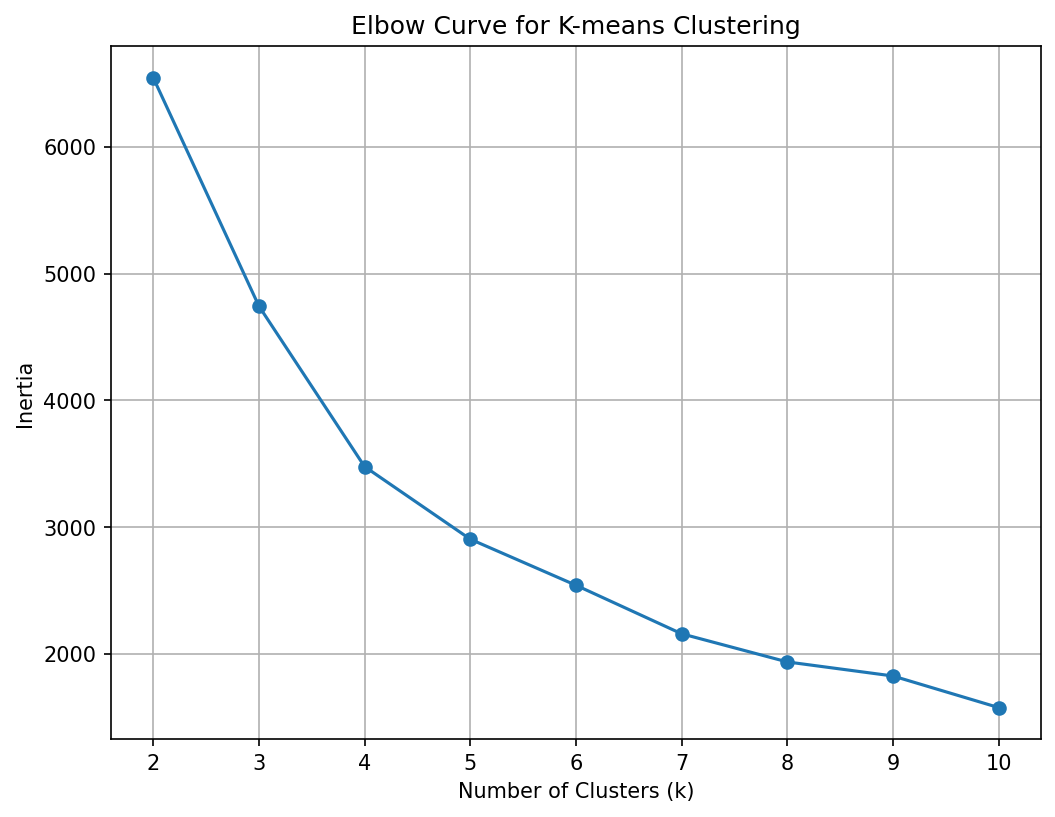

In [61]:
# Calculate inertia (sum of squared distances) for different values of k
inertia = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, n_init= 10, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 6),dpi=150)
plt.plot(range(2, 11), inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Curve for K-means Clustering')
plt.grid(True)
plt.show()

We can keep the number of clusters as 4 as the elbow curve is bending at 4

In [62]:
# Perform K-means clustering with 4
best_kmeans = KMeans(n_clusters=4, n_init=10, random_state=42)
rfm['Cluster'] = best_kmeans.fit_predict(X)

In [63]:
# Group by cluster and calculate mean values
cluster_summary = rfm.groupby('Cluster').agg({
    'R_Score': 'mean',
    'F_Score': 'mean',
    'M_Score': 'mean'
}).reset_index()

In [64]:
cluster_summary

,Cluster,R_Score,F_Score,M_Score
0,0,2.332810,1.159341,1.552590
1,1,4.601621,3.559757,2.931128
2,2,2.876168,2.778037,2.760514
3,3,4.363499,1.404223,1.579186


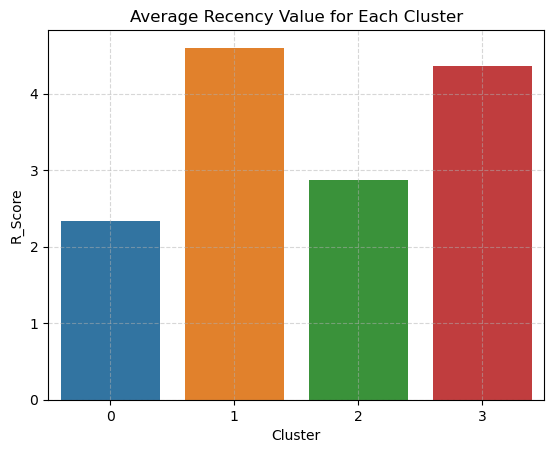

In [65]:
sns.barplot(x='Cluster', y='R_Score', data=cluster_summary)
plt.grid(True, linestyle='--', alpha=0.5)
plt.title('Average Recency Value for Each Cluster')
plt.show()

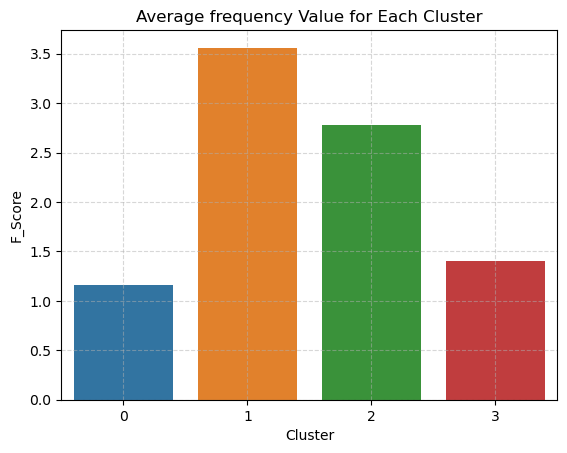

In [66]:
sns.barplot(x='Cluster', y='F_Score', data=cluster_summary)
plt.grid(True, linestyle='--', alpha=0.5)
plt.title('Average frequency Value for Each Cluster')
plt.show()

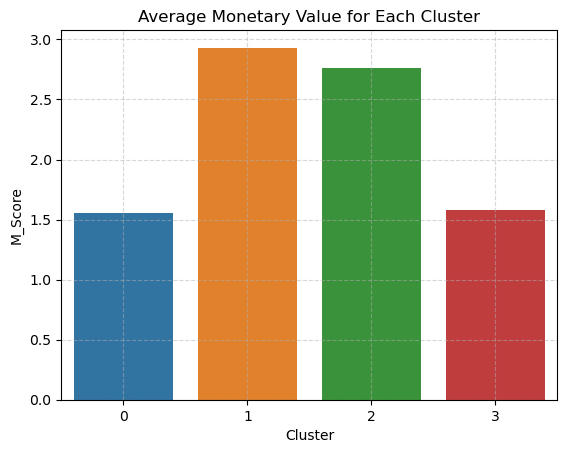

In [67]:
sns.barplot(x='Cluster', y='M_Score', data=cluster_summary)
plt.grid(True, linestyle='--', alpha=0.5)
plt.title('Average Monetary Value for Each Cluster')
plt.show()

### Cluster Analysis with RFM Scores:

#### Cluster 0:
- **R_Score**: 2.33
- **F_Score**: 1.16
- **M_Score**: 1.55

Customers in Cluster 0 have relatively low recency, frequency, and monetary scores compared to other clusters. This suggests that they haven't made purchases recently, don't buy frequently, and spend less money. These customers may be considered as less engaged or lower-value customers.

#### Cluster 1:
- **R_Score**: 4.60
- **F_Score**: 3.56
- **M_Score**: 2.93

Customers in Cluster 1 have high recency, frequency, and monetary scores. They have made recent purchases, buy frequently, and spend a significant amount of money. These customers are highly engaged and valuable to the business. They should be retained and nurtured to encourage further loyalty.

#### Cluster 2:
- **R_Score**: 2.88
- **F_Score**: 2.78
- **M_Score**: 2.76

Customers in Cluster 2 have moderate recency, frequency, and monetary scores. They make purchases relatively recently, buy moderately frequently, and spend a moderate amount of money. These customers represent a balance between engagement and value. Targeted marketing efforts may help in increasing their engagement and loyalty.

#### Cluster 3:
- **R_Score**: 4.36
- **F_Score**: 1.40
- **M_Score**: 1.58

Customers in Cluster 3 have high recency but low frequency and monetary scores. They have made purchases recently but don't buy frequently or spend much money. These customers may be occasional buyers or may need additional incentives to increase their engagement and value to the business.

### Conclusion:
- The clustering analysis helps in identifying different segments of customers based on their RFM scores.
- Cluster 1 represents the most valuable customers, while Cluster 0 and 3 represent less engaged or lower-value customers.
- Understanding the characteristics of each cluster can guide targeted marketing strategies to optimize customer engagement, retention, and loyalty.


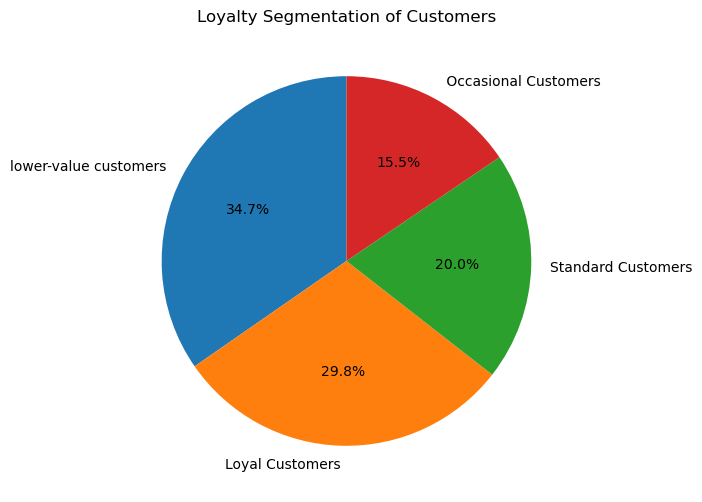

In [68]:
cluster_counts = rfm['Cluster'].value_counts()
# Calculate the total number of customers
total_customers = cluster_counts.sum()

# Calculate the percentage of customers in each cluster
percentage_customers = (cluster_counts / total_customers) * 100

labels = ['lower-value customers','Loyal Customers','Standard Customers',' Occasional Customers']

# Create a pie chart
plt.figure(figsize=(8, 6),dpi=100)
plt.pie(percentage_customers, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Loyalty Segmentation of Customers')
plt.show()